# <center> Предсказание пола клиента </center>

### Необходимо выявить пол клиента, основываясь на его транзакционных исторических данных. В роли метрики качества выступает [ROC AUC](https://dyakonov.org/2017/07/28/auc-roc-%D0%BF%D0%BB%D0%BE%D1%89%D0%B0%D0%B4%D1%8C-%D0%BF%D0%BE%D0%B4-%D0%BA%D1%80%D0%B8%D0%B2%D0%BE%D0%B9-%D0%BE%D1%88%D0%B8%D0%B1%D0%BE%D0%BA/), который и нужно будет максимизировать.

## Описание файлов
- transactions.csv - исторические транзакции банковских клиентов
- gender.csv - информация по полу для части клиентов (null - для тестовых)
- tr_mcc_codes.csv - mcc-коды транзакций
- tr_types.csv - типы транзакций

## Описание полей
### transactions.csv
- customer_id - идентификатор клиента
- tr_datetime - день и время совершения транзакции (дни нумеруются с начала данных)
- mcc_code - mcc-код транзакции
- tr_type - тип транзакции
- amount - сумма транзакции в условных единицах; со знаком "+" — начисление средств клиенту, "-" — списание средств
- term_id - идентификатор терминала

### gender.csv
- customer_id - идентификатор клиента
- gender - пол клиента (пустые значения - тестовые клиенты)

### tr_mcc_codes.csv
- mcc_code - mcc-код транзакции
- mcc_description - описание mcc-кода транзакции

### tr_types.csv
- tr_type - тип транзакции
- tr_description - описание типа транзакции

## Задачи:
- Разработать модель бинарной классификации для определения пола клиента. Никаких ограничений к модели - может быть что угодно от KNN до трансформеров. Главное, чтобы ROC AUC на отложенном тесте получился выше 77.5%.
- Интерпретировать результаты модели: важность входящих в нее переменных, демонстрация на нескольких примерах, почему получился соответствующий прогноз. Последнее позволит понять, какой пол к какому из таргетов (0/1) принадлежит. Опять же, полная свобода выбора подходов! Полезные ключевые слова: gain, permutation importance, SHAP. 
- Конвертировать результаты в отчет без кода (идеально - напрямую в [html](https://stackoverflow.com/questions/49907455/hide-code-when-exporting-jupyter-notebook-to-html))

#### P.S. Не забываем про [PEP8](https://www.python.org/dev/peps/pep-0008/)!

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from scipy.stats import ttest_ind

from sklearn.model_selection import train_test_split, cross_val_score, KFold
import sklearn
sklearn.set_config(transform_output="pandas")

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, auc
import optuna
from datetime import datetime
import shap
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### 1. Знакомство с данными

Подгружаем данные

In [3]:
gender = pd.read_csv('data/gender.csv')
tr_mcc_codes = pd.read_csv('data/tr_mcc_codes.csv', sep=';', encoding='utf-8')
tr_types = pd.read_csv('data/tr_types.csv', sep=';')
transactions = pd.read_csv('data/transactions.csv')

In [4]:
def subscription(df):
    print(df.info())
    print(df.head())
    print(df.isna().sum())

Исторические транзакции банковских клиентов

In [5]:
subscription(transactions)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6849346 entries, 0 to 6849345
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   customer_id  int64  
 1   tr_datetime  object 
 2   mcc_code     int64  
 3   tr_type      int64  
 4   amount       float64
 5   term_id      object 
dtypes: float64(1), int64(3), object(2)
memory usage: 313.5+ MB
None
   customer_id tr_datetime  mcc_code  tr_type    amount term_id
0     39026145  0 10:23:26      4814     1030  -2245.92     NaN
1     39026145  1 10:19:29      6011     7010  56147.89     NaN
2     39026145  1 10:20:56      4829     2330 -56147.89     NaN
3     39026145  1 10:39:54      5499     1010  -1392.47     NaN
4     39026145  2 15:33:42      5499     1010   -920.83     NaN
customer_id          0
tr_datetime          0
mcc_code             0
tr_type              0
amount               0
term_id        2765195
dtype: int64


Типы транзакций

In [6]:
subscription(tr_types)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tr_type         155 non-null    int64 
 1   tr_description  155 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.5+ KB
None
   tr_type                                     tr_description
0     3200  Плата за предоставление услуг посредством моби...
1     3210  Плата за предоставление отчета по счету карты ...
2     3800  Плата за обслуживание банковской карты (за пер...
3     4000            Плата за получение наличных в Сбербанке
4     4001  Плата за получение наличных в Сбербанке (в дру...
tr_type           0
tr_description    0
dtype: int64


Mcc-коды транзакций

In [7]:
subscription(tr_mcc_codes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   mcc_code         184 non-null    int64 
 1   mcc_description  184 non-null    object
dtypes: int64(1), object(1)
memory usage: 3.0+ KB
None
   mcc_code                                    mcc_description
0       742                                Ветеринарные услуги
1      1711  Генеральные подрядчики по вентиляции, теплосна...
2      1731                        Подрядчики по электричеству
3      1799  Подрядчики, специализированная торговля — нигд...
4      2741           Разнообразные издательства/печатное дело
mcc_code           0
mcc_description    0
dtype: int64


Информация по полу для части клиентов (null - для тестовых)

In [8]:
subscription(gender)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  12000 non-null  int64  
 1   gender       8400 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 187.6 KB
None
   customer_id  gender
0      6740969     1.0
1     36599781     0.0
2     91453656     1.0
3     17431962     1.0
4     72568668     1.0
customer_id       0
gender         3600
dtype: int64


Посмотрим распределение таргета

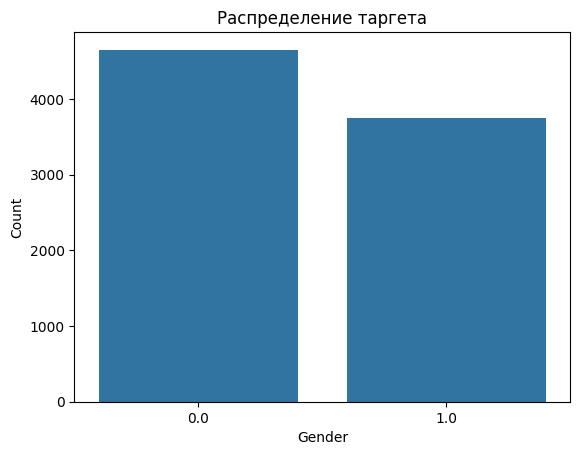

In [9]:
sns.countplot(x='gender', data=gender)
plt.title('Распределение таргета')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

Выводы:  
Таргет не имеет классового дизбаланса.   
Во всех данных, исключая исторические транзакции банковских клиентов отсутствуют пропуски. В данных по транзакциям пропущено 2 765 195 значений в колонке term_id, а это 40% от общего объема данных. Принято решение удалить фичу term_id.  
  
В исторической транзакции банковских клиентов 6 849 346 строк.  
Как вариант можно снизить размерность таблицы, сгруппировав данные по customer_id. В таком случае обучение пройдет быстрее, но потеряются часть данных, в частности характеристика времени.  
Также можно привязать таргет (gender) по customer_id и провести анализ по корреляции данных. Для проверки корреляции между временем в формате timestamp и таргетом можно использовать коэффициент корреляции Пирсона или Спирмена.  
  
Принято решение выбрать вариант снижения размерности таблицы, просуммировав количество кажого типа и mcc кода транзакции для каждого customer_id. Если точность такого варианта не удовлетворит ТЗ, вернуться к варианту с созранением временного ряда.

### 2. Предобработка

Группируем данные по customer_id, просуммировав количество кажого типа и mcc кода транзакции

In [10]:
mcc_features = pd.get_dummies(transactions['mcc_code']).groupby(transactions['customer_id']).sum()
tr_type_features = pd.get_dummies(transactions['tr_type'], prefix='tr_type').groupby(transactions['customer_id']).sum()
positive_cash = transactions[transactions['amount'] > 0].groupby('customer_id')['amount'].sum().rename('add_cash')
negative_cash = transactions[transactions['amount'] < 0].groupby('customer_id')['amount'].sum().rename('withdraw_cash')


Переименование колонок в mcc_features в mcc_description

In [11]:
mcc_description_dict = dict(zip(tr_mcc_codes['mcc_code'], tr_mcc_codes['mcc_description']))
mcc_features_renamed = mcc_features.rename(columns=mcc_description_dict)

Объединим все полученые переменные

In [12]:
features = pd.concat([mcc_features_renamed, tr_type_features, positive_cash, negative_cash], axis=1)
features.fillna(0, inplace=True)

Добавим таргет к данным

In [13]:
merged_df = features.merge(gender, on='customer_id', how='left')

Посмотрим на результат

In [14]:
merged_df.head()

,customer_id,Ветеринарные услуги,"Генеральные подрядчики по вентиляции, теплоснабжению, и водопроводу",Подрядчики по электричеству,"Подрядчики, специализированная торговля — нигде более не классифицированные",Разнообразные издательства/печатное дело,"Авиалинии, авиакомпании",Агентства по аренде автомобилей,"Жилье — отели, мотели, курорты","Транспортировка — пригородные и локальные сезонные транспортные средства, включая электрички",...,tr_type_7070,tr_type_7071,tr_type_7074,tr_type_7075,tr_type_8100,tr_type_8145,tr_type_8146,add_cash,withdraw_cash,gender
0,6815,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2706553.10,-3956007.97,NaN
1,22899,0,0,0,0,0,0,0,0,0,...,9,3,0,1,0,0,0,5818923.05,-6448719.64,1.0
2,27914,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,409879.70,-3386906.52,1.0
3,28753,0,0,0,0,0,0,0,0,0,...,14,0,0,0,0,0,0,45707408.97,-72253691.83,0.0
4,31385,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1251334.45,-3431338.03,0.0


Количество фичей

In [15]:
len(merged_df.columns)

265

### 3. Статистика

Исходя из того, что все данные числовые, можно провести t-test и отбросить фичи, которые не являются статистически значимыми.

In [16]:
drop_list = []
for num_feature in merged_df.iloc[:, 1:].columns.tolist():
    group_1 = merged_df[merged_df['gender'] == 1][num_feature]
    group_2 = merged_df[merged_df['gender'] == 0][num_feature]
    t_statistic, p_value = ttest_ind(group_1, group_2, equal_var=False)
    if p_value >= 0.05:
        drop_list.append(num_feature)

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.


Список фичей, которые не являются статистически значимыи

In [17]:
print(drop_list)

['Подрядчики, специализированная торговля — нигде более не классифицированные', 'Разнообразные издательства/печатное дело', 'Транспортировка — пригородные и локальные сезонные транспортные средства, включая электрички', 'Пассажирские железные перевозки', 'Автобусные линии', 'Агентства по автотранспортным перевозкам, местные/дальные автогрузоперевозки, компании попереезду и хранению, местная доставка', 'Услуги курьера — по воздуху и на земле, агентство по отправке грузов', 'Круизные линии', 'Авиалинии, авиакомпании, нигде более не классифицированные', 'Туристические агентства и организаторы экскурсий', 'Услуги по транспортировке — нигде более не классифицированные', 'Денежные переводы', 'Коммунальные услуги — электричество, газ, санитария, вода', 'Стоматологическое/лабороторное/медицинское/офтальмологическое стационарное оборудование и устройства', 'Промышленное оборудование — нигде более не классифицированное', 'Драгоценные камни и металлы, часы и ювелирные изделия', 'Товары длительног

Сохраним датасет с фичами из списка

In [18]:
filtered_df = merged_df.drop(columns=drop_list)

Количество фичей после фильтрования

In [19]:
len(filtered_df.columns)

130

### 4. Подготовка данных для обучения модели. Какой пол к какому из таргетов (0/1) принадлежит.

Разделим данные на тренировочные и тестовые

In [20]:
test = merged_df[pd.isnull(merged_df['gender'])]
train = merged_df.dropna(subset=['gender'])

test_filtered = filtered_df[pd.isnull(filtered_df['gender'])]
train_filtered = filtered_df.dropna(subset=['gender'])

Сохраним customer_id для тестовой выборки, для проверки результата, если это потребуется

In [21]:
customer_id_test = test['customer_id']

Удалим customer_id из данных, т.к. эта фича не поможет в формировании предсказания

In [22]:
test = test.drop(columns='customer_id')
train = train.drop(columns='customer_id')

test_filtered = test_filtered.drop(columns='customer_id')
train_filtered = train_filtered.drop(columns='customer_id')

Для того, чтобы определиться какой пол к какому из таргетов (0/1) принадлежит возникла идея сгруппировать таблицу train по таргету и просуммировать все фичи. После найти коды операций, количество которых резко отличается для категории таргета 1 и 0.  

Для этого оставим только фичи с типом транзакции mcc

In [23]:
pattern = re.compile('[а-яА-Я]')
features_to_remove = [col for col in train.columns if col != 'gender' and not pattern.search(col)]
gender_find_data = train.drop(columns=features_to_remove)

In [24]:
gender_find_data.head()

,Ветеринарные услуги,"Генеральные подрядчики по вентиляции, теплоснабжению, и водопроводу",Подрядчики по электричеству,"Подрядчики, специализированная торговля — нигде более не классифицированные",Разнообразные издательства/печатное дело,"Авиалинии, авиакомпании",Агентства по аренде автомобилей,"Жилье — отели, мотели, курорты","Транспортировка — пригородные и локальные сезонные транспортные средства, включая электрички",Пассажирские железные перевозки,...,Организации благотворительные и общественные службы,"Ассоциации — гражданские, социальные и братские","Организации, членства, нигде ранее не классифицируемые","Профессиональные услуги, нигде ранее не классифицируемые","Судовые выплаты, включая алименты и детскую поддержку",Штрафы,Налоговые платежи,"Правительственные услуги, нигде ранее не классифицируемые",Почтовые услуги — только правительство,gender
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
5,0,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0.0


Сгруппируем данные по фиче gender, просуммировав остаток фичей и посчитаем дельту для каждой фичи по gender.

In [25]:
gender_find_data.groupby('gender').sum()

,Ветеринарные услуги,"Генеральные подрядчики по вентиляции, теплоснабжению, и водопроводу",Подрядчики по электричеству,"Подрядчики, специализированная торговля — нигде более не классифицированные",Разнообразные издательства/печатное дело,"Авиалинии, авиакомпании",Агентства по аренде автомобилей,"Жилье — отели, мотели, курорты","Транспортировка — пригородные и локальные сезонные транспортные средства, включая электрички",Пассажирские железные перевозки,...,Образовательные услуги,Организации благотворительные и общественные службы,"Ассоциации — гражданские, социальные и братские","Организации, членства, нигде ранее не классифицируемые","Профессиональные услуги, нигде ранее не классифицируемые","Судовые выплаты, включая алименты и детскую поддержку",Штрафы,Налоговые платежи,"Правительственные услуги, нигде ранее не классифицируемые",Почтовые услуги — только правительство
gender,,,,,,,,,,,,,,,,,,,,,
0.0,115,14,5,25,7,779,7,50,863,4106,...,100,215,481,16,7339,24,84,42,337,23
1.0,39,53,51,59,13,1096,32,216,955,3607,...,64,124,325,33,5569,7,182,62,607,20


In [26]:
res = gender_find_data.groupby('gender').sum().loc[0] - gender_find_data.groupby('gender').sum().loc[1]

Полученный список отсортируем и посмотрим 10 самых небольших и самых маленьких значений

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


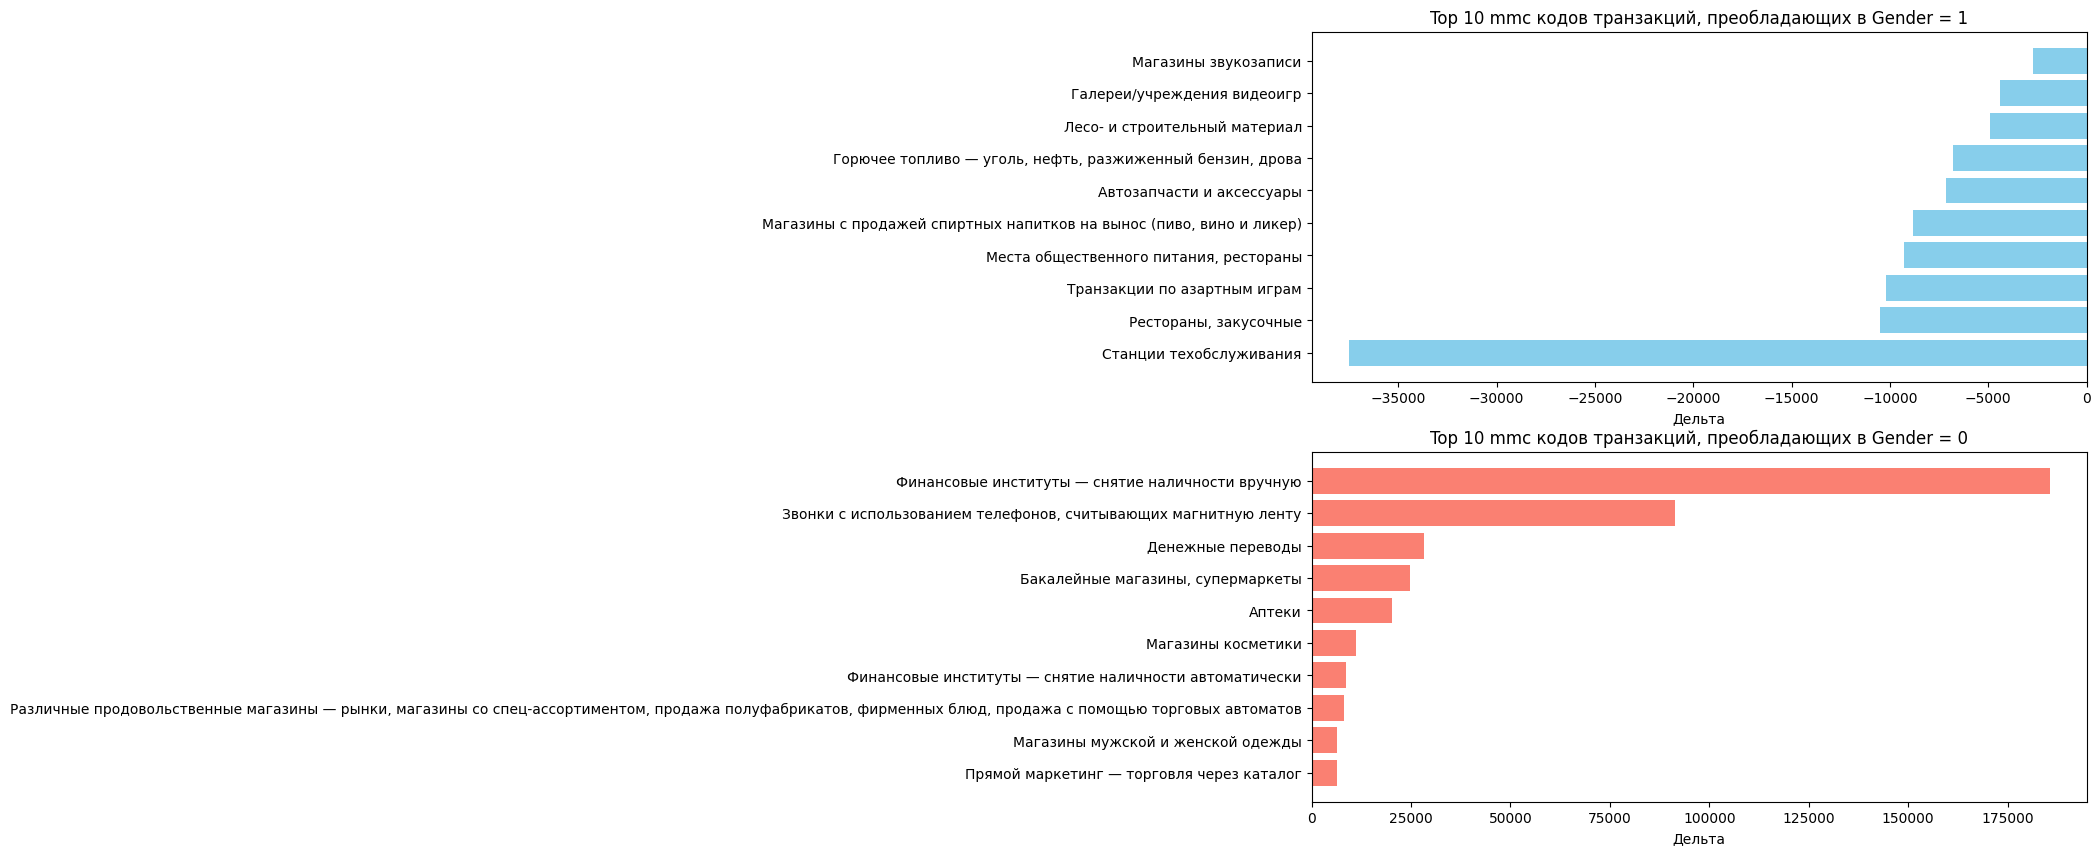

In [48]:
top_10 = pd.DataFrame(res).sort_values(by=0, ascending=True).head(10)
bottom_10 = pd.DataFrame(res).sort_values(by=0, ascending=True).tail(10)

# Создание графика
plt.figure(figsize=(10, 10))

# График для top 10
plt.subplot(2, 1, 1)
plt.barh(top_10.index, top_10[0], color='skyblue')
plt.xlabel('Дельта')
plt.title('Top 10 mmc кодов транзакций, преобладающих в Gender = 1')

# График для bottom 10
plt.subplot(2, 1, 2)
plt.barh(bottom_10.index, bottom_10[0], color='salmon')
plt.xlabel('Дельта')
plt.title('Top 10 mmc кодов транзакций, преобладающих в Gender = 0')

plt.tight_layout()  # автоматическое корректирование расположения графиков
plt.show()

Вывод: Т.к. мы вычитали из значений с gender 0 значения с gender 1, отрицательные значения получены в случае, где количество mcc транзакций преобладают в gender 1.  
  
Исходя из того, что в отрицательных значениях получили:
1. Станции техобслуживания
2. Автозапчасти и аксессуары
3. Горючее топливо — уголь, нефть, разжиженный бензин, дрова
4. Лесо- и строительный материал

А в положительных:
1. Бакалейные магазины, супермаркеты
2. Магазины косметики
3. Магазины мужской и женской одежды

Простите мой сексизм, но можно сделать вывод, что gender 0 - женщины, а gender 1 - мужчины.

### 5. ML секция

Переименуем названия фичей, т.к. некоторые модели не принимают кирилические символы

In [28]:
mcc_description_dict = dict(zip(tr_mcc_codes['mcc_description'], tr_mcc_codes['mcc_code'].apply(lambda x: f'mcc_{x}')))
train = train.rename(columns=mcc_description_dict)
train_filtered = train_filtered.rename(columns=mcc_description_dict)
test = test.rename(columns=mcc_description_dict)
test_filtered = test_filtered.rename(columns=mcc_description_dict)

Разделение датасета на признаки (X) и целевую переменную (y)

In [29]:
X = train.iloc[:, :-1]
y = train.iloc[:, -1]
X_test = test.iloc[:, :-1]

X_filtered = train_filtered.iloc[:, :-1]
y_filtered = train_filtered.iloc[:, -1]
X_test_filtered = test_filtered.iloc[:, :-1]

Разделение на обучающий и тестовый сеты

In [30]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_filtered, X_valid_filtered, y_train_filtered, y_valid_filtered = train_test_split(X_filtered, y_filtered, 
                                                                                          test_size=0.2, random_state=42)

Обучим несколько моделей на датасетах с отфильтрованными фичами и без и оценим точность предсказания. В качестве мооделей выбраны:  
- logistic regression, как быстрый инструмент, который может показать хорошие результаты на разреженной матрице
- random forest, как представитель моделей бэггинга
- catboot, LGBM, XGB, как классическая тройка моделей бустинга  
  
Для скаляции данных используется MinMaxScaler, т.к. размах некоторых фичей отличается на 5-6 порядков.  

Начнем с отфильтрованных данных.

In [31]:
rf = RandomForestClassifier(n_estimators=30, random_state=1)
cb = CatBoostClassifier(eval_metric='Accuracy', verbose=False)
lr = LogisticRegression()
lgb = LGBMClassifier(n_estimators=10, verbose=0)
vc = VotingClassifier(
    [
        ('LogisticRegression', lr),
        ('CatBoost', cb)
    ]
)

xgb = XGBClassifier()

models = [rf, cb, lgb, xgb, lr, vc]
cv = KFold(n_splits=5, random_state=96, shuffle=True)

result_list = []
for i in models:
    ml_pipeline = Pipeline(
        [
            ('preprocessor', MinMaxScaler()),
            ('model', i)
        ]
    )

    cv_accuracy = cross_val_score(
        ml_pipeline,
        X_filtered,
        y_filtered,
        cv=cv,
        scoring='accuracy'
    )

    cv_roc_auc = cross_val_score(
        ml_pipeline,
        X_filtered,
        y_filtered,
        cv=cv,
        scoring='roc_auc'
    )

    result_list.append({'accuracy': round(cv_accuracy.mean(), 3),
                        'roc_auc': round(cv_roc_auc.mean(), 3)})

cross_score = pd.DataFrame(result_list, index=['RandomForest', 'CatBoost', 'LightGBM', 'XGBoost', 'LogisticRegression', 'Vot_CB+LR'])
cross_score

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/id/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 459, in _score
    y_pred = method_caller(clf, "decision_function", X, pos_label=pos_label)
  File "/Users/id/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "/Users/id/miniforge3/lib/python3.10/site-packages/sklearn/utils/_response.py", line 181, in _get_response_values
    prediction_method = _check_response_method(estimator, response_method)
  File "/Users/id/miniforge3/lib/python3.10/site-packages/sklearn/utils/validation.py", line 1939, in _check_response_method
    raise AttributeError(
AttributeError: Pipeline has none of the following attributes: decision_function.

During handling of the above exception, another exception occurred:

Traceback (most recent cal

,accuracy,roc_auc
RandomForest,0.761,0.835
CatBoost,0.791,0.874
LightGBM,0.740,0.822
XGBoost,0.774,0.860
LogisticRegression,0.722,0.822
Vot_CB+LR,0.730,NaN


Повторим для данных без фильтра.

In [32]:
rf = RandomForestClassifier(n_estimators=30, random_state=1)
cb = CatBoostClassifier(eval_metric='Accuracy', verbose=False)
lr = LogisticRegression()
lgb = LGBMClassifier(n_estimators=10, verbose=0)
vc = VotingClassifier(
    [
        ('LogisticRegression', lr),
        ('CatBoost', cb)
    ]
)

xgb = XGBClassifier()

models = [rf, cb, lgb, xgb, lr, vc]
cv = KFold(n_splits=5, random_state=96, shuffle=True)

result_list = []
for i in models:
    ml_pipeline = Pipeline(
        [
            ('preprocessor', MinMaxScaler()),
            ('model', i)
        ]
    )

    cv_accuracy = cross_val_score(
        ml_pipeline,
        X,
        y,
        cv=cv,
        scoring='accuracy'
    )

    cv_roc_auc = cross_val_score(
        ml_pipeline,
        X,
        y,
        cv=cv,
        scoring='roc_auc'
    )

    result_list.append({'accuracy': round(cv_accuracy.mean(), 3),
                        'roc_auc': round(cv_roc_auc.mean(), 3)})

cross_score = pd.DataFrame(result_list, index=['RandomForest', 'CatBoost', 'LightGBM', 'XGBoost', 'LogisticRegression', 'Vot_CB+LR'])
cross_score

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/id/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 459, in _score
    y_pred = method_caller(clf, "decision_function", X, pos_label=pos_label)
  File "/Users/id/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "/Users/id/miniforge3/lib/python3.10/site-packages/sklearn/utils/_response.py", line 181, in _get_response_values
    prediction_method = _check_response_method(estimator, response_method)
  File "/Users/id/miniforge3/lib/python3.10/site-packages/sklearn/utils/validation.py", line 1939, in _check_response_method
    raise AttributeError(
AttributeError: Pipeline has none of the following attributes: decision_function.

During handling of the above exception, another exception occurred:

Traceback (most recent cal

,accuracy,roc_auc
RandomForest,0.756,0.832
CatBoost,0.792,0.875
LightGBM,0.742,0.823
XGBoost,0.776,0.859
LogisticRegression,0.722,0.818
Vot_CB+LR,0.729,NaN


Из полученных метрик делаем вывод, что стат тест привел к сохранению точности при снижении размерности в 2 раза и сокращении времени расчета на 27%.  

Дальнейшие расчеты будут производиться на данных полученных после проведения t-теста.

Проведем тюнинг самой удачной модели

In [33]:
results_list = []

def objective(trial):
    classifier_name = 'CatBoost'
    
    cb_iterations = trial.suggest_int('iterations', 2, 200, step=2)
    cb_learning_rate = trial.suggest_float('learning_rate', 0.02, 0.1)
    cb_max_depth = trial.suggest_int('max_depth', 2, 10, step=1)
    classifier_obj = CatBoostClassifier(eval_metric='AUC', verbose=False, iterations=cb_iterations, learning_rate=cb_learning_rate, max_depth=cb_max_depth)

    ml_pipeline = Pipeline([
        ('preprocessor', MinMaxScaler()),
        ('model', classifier_obj)
    ])

    cv = KFold(n_splits=5, random_state=666, shuffle=True)
    scoring_metric = 'roc_auc'
    scores = cross_val_score(ml_pipeline, X_filtered, y_filtered, cv=cv, scoring=scoring_metric)
    roc_auc = scores.mean()
    
    global results_df
    results_list.append({'Classifier': classifier_name, 'ROC_AUC': roc_auc})
    
    return roc_auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

best_params = study.best_params
best_value = study.best_value

[I 2024-03-15 12:52:44,656] A new study created in memory with name: no-name-1d08b5d4-c900-40c6-a433-3865b660c28a
[I 2024-03-15 12:52:45,192] Trial 0 finished with value: 0.8381476863564743 and parameters: {'iterations': 22, 'learning_rate': 0.09552166265120521, 'max_depth': 6}. Best is trial 0 with value: 0.8381476863564743.
[I 2024-03-15 12:52:50,290] Trial 1 finished with value: 0.8612664251151332 and parameters: {'iterations': 52, 'learning_rate': 0.08084575245130576, 'max_depth': 10}. Best is trial 1 with value: 0.8612664251151332.
[I 2024-03-15 12:52:52,506] Trial 2 finished with value: 0.8426746906484255 and parameters: {'iterations': 22, 'learning_rate': 0.07888534420936087, 'max_depth': 10}. Best is trial 1 with value: 0.8612664251151332.
[I 2024-03-15 12:52:54,686] Trial 3 finished with value: 0.8494964276629189 and parameters: {'iterations': 164, 'learning_rate': 0.027992882910809102, 'max_depth': 4}. Best is trial 1 with value: 0.8612664251151332.
[I 2024-03-15 12:53:00,076

Посмотрим лучшие параметры

In [34]:
print(f"Лучшие параметры: {best_params}")
print(f"Лучшее значение: {best_value}")

Лучшие параметры: {'iterations': 198, 'learning_rate': 0.06932899177419524, 'max_depth': 7}
Лучшее значение: 0.8712663940621267


Обучим модель с использованием параметров, которые показали лучшие результаты

In [41]:
train_pipeline = Pipeline(
    [
        ('preprocessor', MinMaxScaler()),
        ('model', CatBoostClassifier(iterations=198, learning_rate=0.06932899177419524, max_depth=7))
    ]
)

valid_ml = train_pipeline.fit(X_train_filtered, y_train_filtered)

0:	learn: 0.6787292	total: 5.27ms	remaining: 1.04s
1:	learn: 0.6610948	total: 11.1ms	remaining: 1.08s
2:	learn: 0.6466479	total: 17.1ms	remaining: 1.11s
3:	learn: 0.6324065	total: 22.1ms	remaining: 1.07s
4:	learn: 0.6228061	total: 26.8ms	remaining: 1.03s
5:	learn: 0.6107895	total: 31.1ms	remaining: 997ms
6:	learn: 0.5999068	total: 36ms	remaining: 983ms
7:	learn: 0.5887532	total: 40.8ms	remaining: 969ms
8:	learn: 0.5819262	total: 45.2ms	remaining: 950ms
9:	learn: 0.5747599	total: 52.5ms	remaining: 988ms
10:	learn: 0.5693747	total: 58.1ms	remaining: 988ms
11:	learn: 0.5628014	total: 64ms	remaining: 992ms
12:	learn: 0.5574008	total: 68.4ms	remaining: 974ms
13:	learn: 0.5525892	total: 73.5ms	remaining: 965ms
14:	learn: 0.5471757	total: 78ms	remaining: 952ms
15:	learn: 0.5421808	total: 83ms	remaining: 944ms
16:	learn: 0.5370411	total: 88.5ms	remaining: 942ms
17:	learn: 0.5327532	total: 94.2ms	remaining: 942ms
18:	learn: 0.5295772	total: 98.2ms	remaining: 925ms
19:	learn: 0.5256959	total: 10

Сделаем предсказание для валидационной выборки и построим кривую ROC-AUC

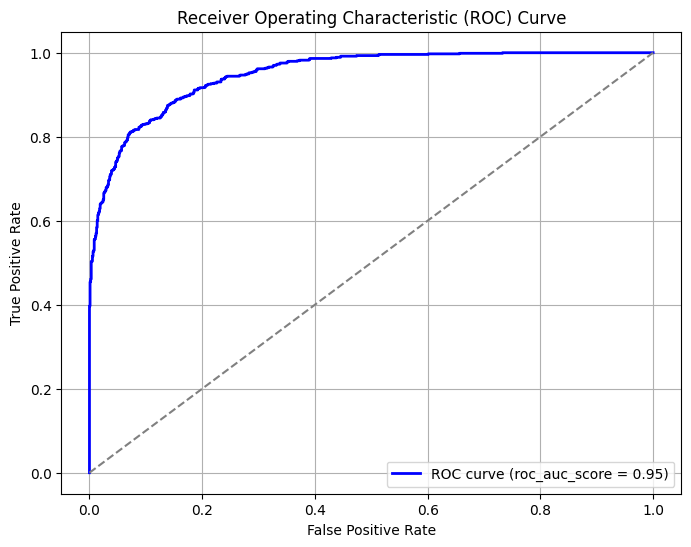

In [57]:
pred_proba_valid = valid_ml.predict_proba(X_valid_filtered)

# Вычисление параметров ROC-кривой
fpr, tpr, thresholds = roc_curve(y_valid_filtered, pred_proba_valid[:, 1])
roc_auc = roc_auc_score(y_valid_filtered, pred_proba_valid[:, 1])

# Построение ROC-кривой
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (roc_auc_score = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show();

Подход, который выбран изначально удовлетворяет условиям задачи.  

Обучим модель на данных после тюнинга на максимальном объеме данных (тренировочные + валидационные) для формирования предсказания для тестовой выборки.

In [43]:
trained_ml = train_pipeline.fit(X_filtered, y_filtered)

0:	learn: 0.6753451	total: 6.1ms	remaining: 1.2s
1:	learn: 0.6583512	total: 12.5ms	remaining: 1.22s
2:	learn: 0.6430495	total: 18ms	remaining: 1.17s
3:	learn: 0.6281805	total: 24.1ms	remaining: 1.17s
4:	learn: 0.6162796	total: 29.7ms	remaining: 1.15s
5:	learn: 0.6077530	total: 35.9ms	remaining: 1.15s
6:	learn: 0.5984534	total: 41.6ms	remaining: 1.13s
7:	learn: 0.5885294	total: 48.5ms	remaining: 1.15s
8:	learn: 0.5809056	total: 53.6ms	remaining: 1.13s
9:	learn: 0.5733737	total: 63.3ms	remaining: 1.19s
10:	learn: 0.5658487	total: 68.9ms	remaining: 1.17s
11:	learn: 0.5593909	total: 73.6ms	remaining: 1.14s
12:	learn: 0.5537519	total: 78.1ms	remaining: 1.11s
13:	learn: 0.5478626	total: 82.5ms	remaining: 1.08s
14:	learn: 0.5423998	total: 87.3ms	remaining: 1.06s
15:	learn: 0.5380442	total: 91.7ms	remaining: 1.04s
16:	learn: 0.5334833	total: 96.2ms	remaining: 1.02s
17:	learn: 0.5293073	total: 101ms	remaining: 1s
18:	learn: 0.5252975	total: 105ms	remaining: 992ms
19:	learn: 0.5206890	total: 110

Сделаем предсказания для тестовой выборки и соединим полученный данные с customer_id

In [44]:
pred_test = trained_ml.predict(X_test_filtered)

submit = pd.DataFrame()
submit['customer_id'] = customer_id_test
submit['predict'] = pred_test
submit

,customer_id,predict
0,6815,0.0
7,49101,0.0
8,49793,1.0
15,85327,0.0
18,114348,1.0
...,...,...
14992,99969946,1.0
14993,99977292,1.0
14994,99980396,0.0
14995,99984336,0.0


### Общий результат

В процессе работы с данными:  
- была снижена размерность с 34 246 730 элементов до 1 950 000 элементов  
- категорией 0 в таргете обозначены женщины, а 1 - мужчины  
- лучшие результаты по метрикам Accuracy и ROC-AUC показала модель CatBoost  
- итоговая модель делает предсказания с точностью 0.95 по метрике ROC_AUC_SCORE, что удовлетворяет условиям поставленной задачи  
- фичи наиболее влияющие на таргет, а также их распределение указаны ниже

 99%|===================| 6640/6720 [00:50<00:00]        

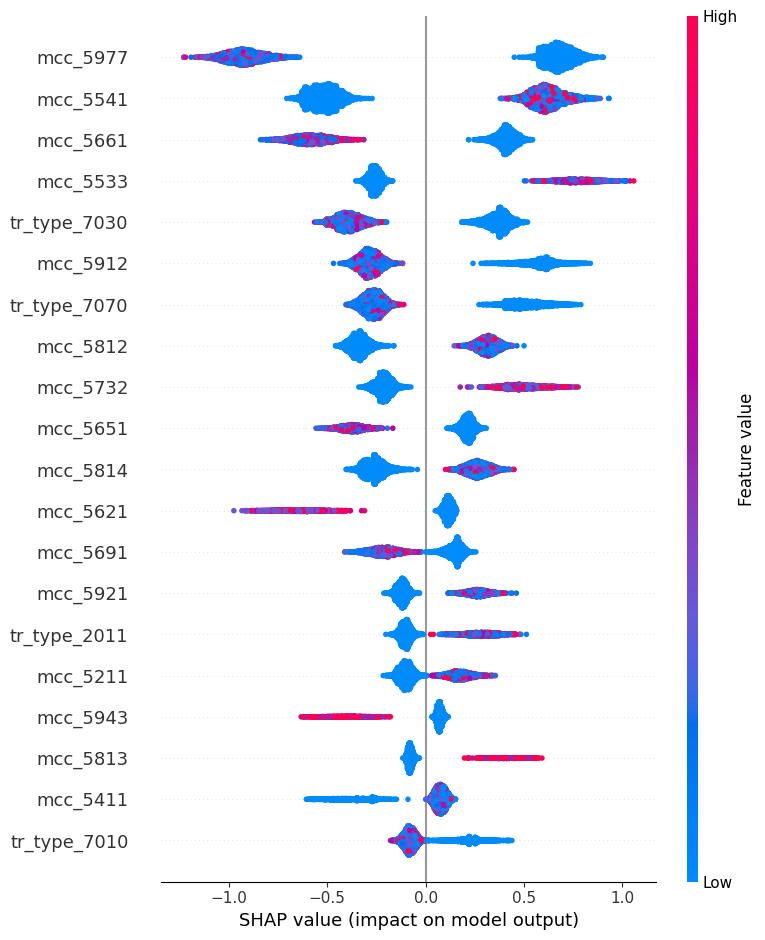

In [45]:
classifier_model = trained_ml.named_steps['model']
explainer = shap.Explainer(classifier_model, X_train_filtered)
shap_values = explainer.shap_values(X_train_filtered)
shap.summary_plot(shap_values, X_train_filtered)

In [58]:
# !jupyter nbconvert --to html --no-input Assessment_solution.ipynb

[NbConvertApp] Converting notebook Assessment_solution.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 4 image(s).
[NbConvertApp] Writing 784261 bytes to Assessment_solution.html
